## Recommendation for Loyal Customers who buys Products Frequently and Recently

Customer2Vec is a good method for these kind of users. As these customers usually repeat their orders and buys frequently. We learn a semantic representation for Customers using their previous purchase history. 

## Customer2Vec

We learn good semantic representations for customers (users) from transactional data using doc2vec. Each customer is a document, orders are sentences, and products are words. We also compare Customer2Vec with the baseline representations obtained using k-means on manually designed features. 


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import os
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

pd.options.display.max_rows = 20
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 500)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob
from IPython.display import display, HTML

import multiprocessing as mp
print('Number of CPU cores:', mp.cpu_count())

Number of CPU cores: 8


## Data Exploration and Preparation

In [3]:
os.chdir(r'N:\Digital Marketing Analytics\Olist DIgital Marketing Analytics\Recommendation\ALS\Webapp')

In [4]:
prior_orders = pd.read_csv('Olist_Recommendation_Dataset.csv')
prior_orders

,Customer State,Review Score,Purchase Timestamp,Purchase Date,Monetary,Customer Segment,Marketing Action,Customer_ID,Order_ID,Product_ID,product_name,aisle,department,Product Category
0,RJ,5,2017-09-13 08:59:02,2017-09-13 00:00:00,281.30,Potential Loyalists,Cross Sell Recommendations and Discount coupons,15438,0,8446,Utility Lighter,more household,household,more household
1,GO,5,2017-06-28 11:52:20,2017-06-28 00:00:00,73.86,Lost Customers,Don't spend too much trying to re-acquire,22529,7229,8446,Utility Lighter,more household,household,more household
2,MG,4,2018-05-18 10:25:53,2018-05-18 00:00:00,108.32,Potential Loyalists,Cross Sell Recommendations and Discount coupons,17139,31508,8446,Utility Lighter,more household,household,more household
3,PR,5,2017-08-01 18:38:42,2017-08-01 00:00:00,472.06,Loyal Customers,Loyality programs;Cross Sell,33008,42252,8446,Utility Lighter,more household,household,more household
4,MG,5,2017-08-10 21:48:40,2017-08-10 00:00:00,1415.74,VVIP - Can't Loose Them,No Price Incentives; Offer Limited edition and Loyality programs,41377,47321,8446,Utility Lighter,more household,household,more household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100846,RJ,1,2017-12-09 13:51:24,2017-12-09 00:00:00,618.88,Potential Loyalists,Cross Sell Recommendations and Discount coupons,3664,94603,14949,Hand Luggage,missing,missing,Hand Luggage
100847,SP,4,2017-07-13 11:24:43,2017-07-13 00:00:00,157.30,Hibernating - Almost Lost,Aggressive price incentives,10847,87800,4042,Chicken Curry with Seasoned Basmati Rice,frozen meals,frozen,frozen meals
100848,SP,3,2018-07-27 10:44:02,2018-07-27 00:00:00,68.35,Potential Loyalists,Cross Sell Recommendations and Discount coupons,32799,88387,8881,Apple Macbook,ice cream ice,frozen,Apple Macbook
100849,SC,5,2018-08-21 11:29:05,2018-08-21 00:00:00,314.32,Potential Loyalists,Cross Sell Recommendations and Discount coupons,40805,90090,13612,Perfumes,candy chocolate,snacks,Perfumes


In [19]:
#features = ['order_id', 'product_id', 'reordered', 'user_id', 'order_number', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department']
#prior_orders = prior_orders[features]

In [20]:
#prior_orders = prior_orders.rename(columns={'product_id':'Product_ID', 'user_id':'Customer_ID', 'order_id':'Order_ID'})

In [5]:
prior_orders.columns

Index(['Customer State', 'Review Score', 'Purchase Timestamp', 'Purchase Date', 'Monetary', 'Customer Segment', 'Marketing Action', 'Customer_ID', 'Order_ID', 'Product_ID', 'product_name', 'aisle', 'department', 'Product Category'], dtype='object')

In [6]:
prior_orders = prior_orders[prior_orders['Customer Segment'] == 'Loyal Customers']
customers= prior_orders.Customer_ID.unique()
customers = customers[:2000]

In [29]:
# Sample users to keep the problem computationaly tractable 
#USER_SUBSET = 15000
#np.random.seed(42)
#user_ids_sample = prior_orders['Customer_ID'].sample(n=USER_SUBSET, replace=False)

In [7]:
prior_orders_details = prior_orders[prior_orders.Customer_ID.isin(customers)].copy()
prior_orders_details.head()

,Customer State,Review Score,Purchase Timestamp,Purchase Date,Monetary,Customer Segment,Marketing Action,Customer_ID,Order_ID,Product_ID,product_name,aisle,department,Product Category
3,PR,5,2017-08-01 18:38:42,2017-08-01 00:00:00,472.06,Loyal Customers,Loyality programs;Cross Sell,33008,42252,8446,Utility Lighter,more household,household,more household
6,BA,5,2018-03-18 21:00:44,2018-03-18 00:00:00,344.52,Loyal Customers,Loyality programs;Cross Sell,7413,71176,8446,Utility Lighter,more household,household,more household
7,GO,5,2017-08-05 16:59:05,2017-08-05 00:00:00,756.33,Loyal Customers,Loyality programs;Cross Sell,27116,76489,8446,Utility Lighter,more household,household,more household
14,TO,3,2017-10-04 09:10:06,2017-10-04 00:00:00,98.53,Loyal Customers,Loyality programs;Cross Sell,993,26929,20672,Vegan Alfredo Sauce Arugula Pesto,MunchPak,dry goods pasta,MunchPak
15,PR,5,2018-01-06 19:17:24,2018-01-06 00:00:00,472.06,Loyal Customers,Loyality programs;Cross Sell,33008,74521,14691,Disposal Cleaner,cleaning products,household,cleaning products


In [8]:
# Create basic user features: relative purchase frequences in each depertment/aisle

feature_department = pd.pivot_table(prior_orders_details, index=['Customer_ID'], values=['Product_ID'], columns=['department'], aggfunc='count', fill_value=0)
feature_department = feature_department.div(feature_department.sum(axis=1), axis=0)
feature_department.columns = feature_department.columns.droplevel(0)
feature_department = feature_department.reset_index()

feature_aisle = pd.pivot_table(prior_orders_details, index=['Customer_ID'], values=['Product_ID'], columns=['aisle'], aggfunc='count', fill_value=0)
feature_aisle = feature_aisle.div(feature_aisle.sum(axis=1), axis=0)
feature_aisle.columns = feature_aisle.columns.droplevel(0)
feature_aisle = feature_aisle.reset_index()

feature_df = feature_department.merge(feature_aisle, how='left', on='Customer_ID').set_index('Customer_ID')

feature_df.iloc[:5, :10] # show first 10 columns (departments) only

,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta
Customer_ID,,,,,,,,,,
12,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
15,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.00,0.0
20,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
29,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0
44,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.25,0.0


## Customer2Vec, Step 1: Data Preparation 

In this and next section, we are learning and exploring the customer semantic space using Doc2Vec.

In [9]:
prior_orders["Product_ID"] = prior_orders["Product_ID"].astype(str)

# It is important to sort order and products chronologically
prior_orders.sort_values(by=['Customer_ID','Order_ID'], inplace=True)

C:\Users\nikhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\nikhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
combined_orders_by_user_id = prior_orders.groupby("Customer_ID").apply(lambda order: ' '.join(order['Product_ID'].tolist()))

combined_orders_by_user_id = pd.DataFrame(combined_orders_by_user_id,columns=['all_orders'])
print(f'Number of orders: {combined_orders_by_user_id.shape[0]}')
combined_orders_by_user_id.reset_index(inplace=True)
combined_orders_by_user_id.Customer_ID = combined_orders_by_user_id.Customer_ID.astype(str)

combined_orders_by_user_id.head(20)

Number of orders: 5335


,Customer_ID,all_orders
0,12,24489 18150 15675
1,15,27919 10407 10194
2,20,3644 28326 1947
3,22,27705 16024 19499
4,29,674 22384 25888
5,42,11218 31057 24169
6,44,22667 5566 29716 19607
7,46,19116 19369 2077
8,56,28436 16374 20887 19928
9,61,4758 27650 4573


## Customer2Vec, Step 2: Train Doc2Vec model

We use implementation from Gensim adjusting the following parameters:
* documents = users (each user is represented by a chronologically sorted list of products)
* window - Maximum distance between the current and predicted word within a sentence.
* vector_size - Dimensionality of the word vectors.
* min_count - Ignores all words with total frequency lower than this.

Note that model training can take a long time (10+ hours).

In [11]:
TRAIN_USER_MODEL = True    # True - create a new model, False - load a previosuly created model
MODEL_DIR = 'models'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [12]:
from gensim.models.doc2vec import LabeledSentence, TaggedDocument, Doc2Vec
import timeit
import gensim

embeddings_dim = 100    # dimensionality of user representation

filename = f'models/customer2vec.{embeddings_dim}d.model'
if TRAIN_USER_MODEL:

    class TaggedDocumentIterator(object):
        def __init__(self, df):
           self.df = df
        def __iter__(self):
            for row in self.df.itertuples():
                yield TaggedDocument(words=dict(row._asdict())['all_orders'].split(),tags=[dict(row._asdict())['Customer_ID']])

    it = TaggedDocumentIterator(combined_orders_by_user_id)

    doc_model = gensim.models.Doc2Vec(vector_size=embeddings_dim, 
                                      window=5, 
                                      min_count=10, 
                                      workers=mp.cpu_count(),
                                      alpha=0.055, 
                                      min_alpha=0.055,
                                      epochs=15)   # use fixed learning rate

    train_corpus = list(it)

    doc_model.build_vocab(train_corpus)

    for epoch in tqdm(range(10)):
        doc_model.alpha -= 0.005                    # decrease the learning rate
        doc_model.min_alpha = doc_model.alpha       # fix the learning rate, no decay
        doc_model.train(train_corpus, total_examples=doc_model.corpus_count, epochs=doc_model.iter)
        print('Iteration:', epoch)

    doc_model.save(filename)
    print(f'Model saved to [{filename}]')
    
else:
    doc_model = Doc2Vec.load(filename)
    print(f'Model loaded from [{filename}]')

unable to import 'smart_open.gcs', disabling that module
C:\Users\nikhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\nikhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9

Model saved to [models/customer2vec.100d.model]


In [13]:
vocab_doc = list(doc_model.docvecs.doctags.keys())
doc_vector_dict = {arg:doc_model.docvecs[arg] for arg in vocab_doc}
X_doc = pd.DataFrame(doc_vector_dict).T.values


X_doc.shape, len(vocab_doc), prior_orders["Customer_ID"].nunique()

((5335, 100), 5335, 5335)

## Customer2Vec, Step 3: Visualize the Customer Semantic Space Using t-SNE

In [14]:
user_ids_sample_str = set([str(id) for id in customers])
idx = []
for i, user_id in enumerate(doc_vector_dict):
    if user_id in user_ids_sample_str:
        idx.append(i)
X_doc_subset = X_doc[idx] # only sampled user IDs
X_doc_subset.shape

(2000, 100)

In [15]:
doc_vec_subset = pd.DataFrame(doc_vector_dict).T.iloc[idx]
doc_vec_subset.shape

(2000, 100)

In [16]:
from sklearn.metrics import pairwise_distances

distance_matrix_doc = pairwise_distances(X_doc_subset, X_doc_subset, metric='cosine', n_jobs=-1)
tsne_doc = TSNE(metric="precomputed", n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_results_doc = tsne_doc.fit_transform(distance_matrix_doc)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.156574
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.127022
[t-SNE] Error after 500 iterations: 1.143864


In [17]:
tsne_doc = pd.DataFrame()
tsne_doc['tsne-2d-one'] = tsne_results_doc[:,0]
tsne_doc['tsne-2d-two'] = tsne_results_doc[:,1]

<Figure size 864x864 with 0 Axes>

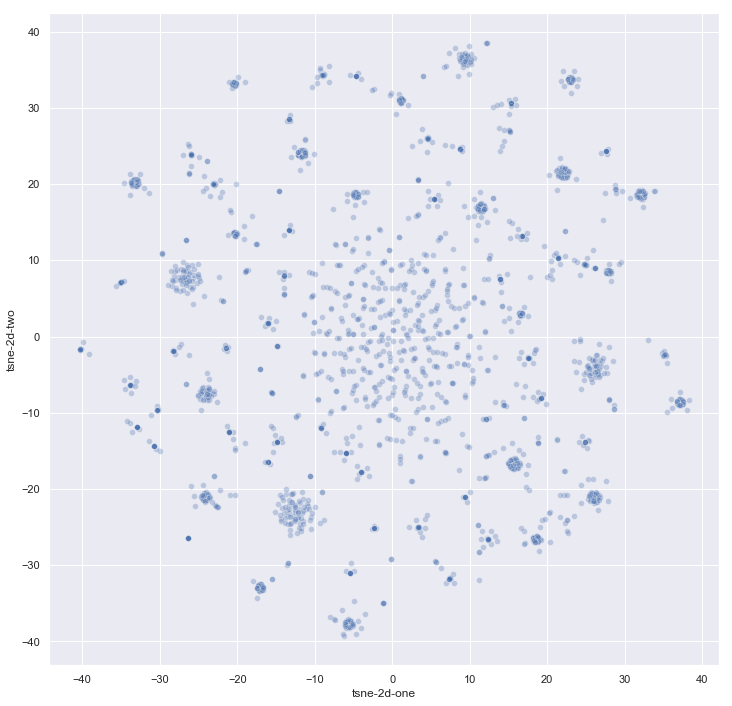

In [18]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=tsne_doc,
    legend="full",
    alpha=0.3
)
plt.show()

## Customer2Vec, Step 4: Segmentation in the Customer Semantic Space Using t-SNE

In [19]:
def cluster_cosine(X, k):
    # normalization is equivalent to cosine distance
    return KMeans(n_clusters=k).fit(preprocessing.normalize(X_doc_subset)).labels_.astype(float)

silhouette_list = []
for k in tqdm(range(2, 15, 1)):
    latent_clusters = cluster_cosine(X_doc_subset, k)
    silhouette_avg = silhouette_score(X_doc_subset, latent_clusters, metric="cosine")
    silhouette_list.append(silhouette_avg)
    print(f'Silhouette score for {k} clusters is : {silhouette_avg:.4}')

C:\Users\nikhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Silhouette score for 2 clusters is : 0.2939
Silhouette score for 3 clusters is : 0.06222
Silhouette score for 4 clusters is : 0.06991
Silhouette score for 5 clusters is : 0.07257
Silhouette score for 6 clusters is : 0.06953
Silhouette score for 7 clusters is : 0.08963
Silhouette score for 8 clusters is : 0.1046
Silhouette score for 9 clusters is : 0.1134
Silhouette score for 10 clusters is : 0.1251
Silhouette score for 11 clusters is : 0.1178
Silhouette score for 12 clusters is : 0.132
Silhouette score for 13 clusters is : 0.1406
Silhouette score for 14 clusters is : 0.1489



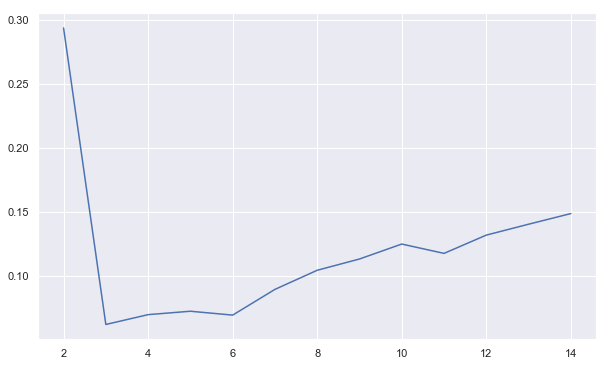

In [20]:
plt.figure(figsize=(10,6))
plt.plot(range(2,15,1), silhouette_list);

In [21]:
N_CLUSTER = 7

latent_clusters = cluster_cosine(X_doc_subset, N_CLUSTER)
doc_vec_end = doc_vec_subset.copy()
doc_vec_end['label'] = latent_clusters
tsne_doc['cluster'] = latent_clusters

doc_vec_end['label'].value_counts()

4.0    453
0.0    370
6.0    325
3.0    293
2.0    293
1.0    160
5.0    106
Name: label, dtype: int64

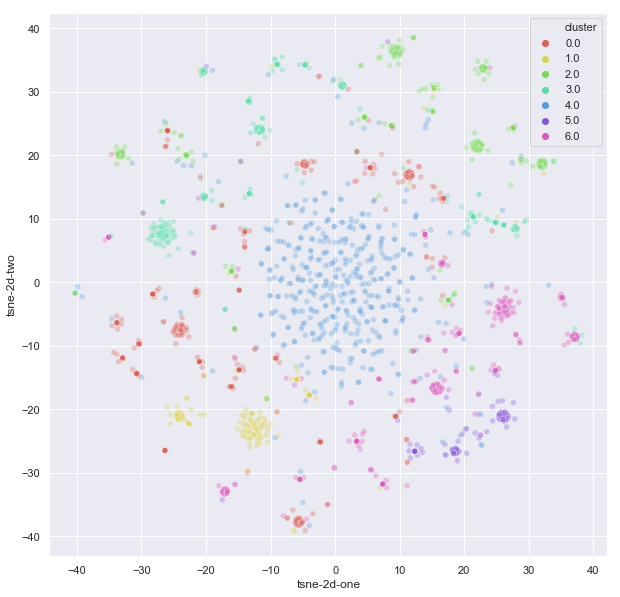

In [22]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='cluster',
    palette=sns.color_palette("hls", tsne_doc['cluster'].nunique()),
    data=tsne_doc,
    legend="full",
    alpha=0.3
);
plt.show();

In [23]:
feature_df['latent_cluster'] = latent_clusters

department_names = np.setdiff1d(prior_orders_details['department'].unique(), ['other', 'missing'])
interpetation_department = feature_df.groupby('latent_cluster')[department_names].mean()

interpetation_department.T.div(interpetation_department.sum(axis=1)).round(3)

latent_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0
alcohol,0.026,0.097,0.015,0.019,0.014,0.010,0.011
babies,0.018,0.015,0.018,0.012,0.021,0.008,0.022
bakery,0.040,0.014,0.037,0.019,0.027,0.026,0.017
beverages,0.069,0.069,0.092,0.126,0.094,0.071,0.081
breakfast,0.016,0.018,0.014,0.021,0.033,0.019,0.024
bulk,0.000,0.000,0.000,0.000,0.001,0.000,0.000
canned goods,0.040,0.021,0.025,0.027,0.029,0.011,0.044
dairy eggs,0.066,0.055,0.048,0.081,0.077,0.043,0.069
deli,0.020,0.020,0.025,0.019,0.032,0.282,0.021
dry goods pasta,0.018,0.028,0.031,0.023,0.048,0.025,0.026


In [24]:
interpetation_aisle = feature_df.groupby('latent_cluster')[feature_df.columns.values[16:-1]].mean()
interpetation_aisle.T.div(interpetation_aisle.sum(axis=1)).round(3).head(20)

latent_cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0
pantry,0.089,0.060,0.058,0.067,0.069,0.060,0.095
personal care,0.073,0.223,0.147,0.088,0.093,0.060,0.071
pets,0.009,0.005,0.013,0.006,0.016,0.010,0.013
produce,0.043,0.021,0.059,0.020,0.024,0.015,0.054
snacks,0.105,0.040,0.069,0.138,0.091,0.121,0.097
Candy Club,0.007,0.004,0.012,0.004,0.007,0.007,0.005
FitSnack,0.008,0.002,0.007,0.005,0.007,0.002,0.004
KetoKrate,0.005,0.011,0.006,0.007,0.011,0.007,0.007
Love with food,0.004,0.018,0.001,0.001,0.001,0.005,0.004
MunchPak,0.002,0.008,0.004,0.004,0.008,0.008,0.005


### Getting Customer ID based Recommendations 

In [48]:
prior_orders_details_clustered = prior_orders_details.copy()
prior_orders_details_clustered = prior_orders_details_clustered.merge(feature_df['latent_cluster'], on='Customer_ID', how='left')

for cluster_id in [1.0, 2.0, 4.0, 3.0]:
    prior_orders_details_clustered[prior_orders_details_clustered['latent_cluster']==cluster_id][['Customer_ID', 'product_name']].groupby("Customer_ID").apply(lambda order: ' > '.join(order['product_name'])).reset_index().head(10)

,Customer_ID,0
0,273,"Permanent Hair Color Dark Chestnut Brown 3N > Waterproof Mascara - 311 Very Black > Gluten Free Granola, Nutty Cranberry Maple, Family Value Size"
1,342,Pro-Health Advanced Extra Deep Clean Anticavity Fluoride Mouthwash > Hand Luggage > Acne Wash > Protein
2,648,Signature Twin Size Mattress > Permanent Hair Color Dark Chestnut Brown 3N > Long Term Relationship Shampoo For Long Hair
3,840,Permanent Hair Color Dark Chestnut Brown 3N > Prosciutto Tortelloni > Tulsi Breakfast Tea
4,915,Permanent Hair Color Dark Chestnut Brown 3N > Cheese Spread Port Wine > Odor Shield Scented Scoopable Cat Litter
5,977,Permanent Hair Color Dark Chestnut Brown 3N > Mex Bouil Tomato Chicken Savoury Sauce > Perfumes
6,1027,Ibuprofen Liquid Softgels > Permanent Hair Color Dark Chestnut Brown 3N > Organic Cheddar Crazy Bugs Macaroni & Cheese Dinner
7,1180,Imported Beer Bottles > Handmade Shmura Matzo > Hobnobs
8,1617,Permanent Hair Color Dark Chestnut Brown 3N > Voluminous Original Mascara - Waterproof Black 360 > Original Coconut Water
9,1736,Imported Beer Bottles > Soft Flour Tortillas > Medium Mango Habanero Salsa


,Customer_ID,0
0,20,Quart Size Mason Jars > Apple Macbook > Tulips 10 Stem
1,150,Signature Twin Size Mattress > Perfect Food Alkalize & Detoxifier RAW Organic Green Super Food > Pizzeria-Style Crust Supreme Speciale Pizza
2,336,Unsweetened Elegant Jasmine Green Tea > Perfumes > Good Buddy Cookies Cheddar Cheese Flavor > Cat Treats Temptations Seafood Medley
3,426,Classic Poultry & Beef Feast Variety Cat Food > Magic Shell Chocolate Fudge > Ultimate Flora 80 Billion Probiotic Vegetable Capsules > Natural Vegetable Laxative Plus Stool Softener Tablets
4,668,Kale Blazer Juice > Perfumes > Evening Primrose 1300 Mg > Fat Free Vitamin A & D Milk
5,793,"Natural Powder Long Lasting Deodorant > Bonito Flakes, Aged and Dried > Everything Bagel,kattle Boiled & Hearth Baked Slice"
6,1077,Chef Size Extra Virgin Olive Oil > High Protein Vanilla Shake > Baked Cheddar Brown Rice Snaps
7,1098,Original Kids Shampoo > Rolled Fillets of Anchovies with Capers In Pure Olive Oil > Casera Medium Salsa
8,1341,High Protein Vanilla Shake > Green Pickled Whole Jalapeno Peppers > Special Edition Hershey's Cookies 'n' Creme Cookies
9,1870,Signature Twin Size Mattress > Organic Superfoods Carrot Rice Cakes > Soft Flour Tortillas


,Customer_ID,0
0,12,Apple Macbook > Organic Whole Strawberries > Oatmeal Raisin Cookies
1,29,Sponge Blossoms > Super Nutrition Vanilla Shake > Italian Dill Pickle Chips
2,61,"Organic Colby Cheese > Total Care Fresh Mint Anticavity Mouthwash > Gum, Sugarfree, Winterfrost"
3,105,Bag of Oranges > Blue 1000 Mg Vitamin C Triple Berry Fizzy Drink Mix > B 50 Complex
4,127,Hand Luggage > Original Vegetarian Formula Papaya Enzyme Chewable Tablets
5,176,Good Buddy Rawhide Pressed Bone > Organic Flax Oil Supplement > Chef's Favorites Lightly Seasoned Asian Medley
6,182,"Popped Potato Snack, Crazy Hot > Long Grain Wild Rice > High Performance Energy Drink"
7,207,Hand Luggage > Lighty Breaded Fishies > Graduates Lil' Entrees Pasta Stars In Meat Sauce With Green Beans
8,276,Garden Delight Rotini > Organic Eggplant Parmesan > Large Organic Omega3 Brown Eggs
9,376,Organic Anti-Bug Shake & Spray > Gluten Free Multi Seed Rice Thin Crackers > Mocha Hot Chocolate


,Customer_ID,0
0,330,Mediterranean Lavender Scent Fabric Refresher Spray > Mixed Nuts Lightly Salted > Green Decorating Gel
1,441,Every Woman's One Daily 40+ Multivitamin > Crispy Wild Alaskan Fish Nuggets > Premium Saline Nasal Spray
2,477,Mixed Nuts Lightly Salted > Beyond Simply 9 Ranch Raised Lamb & Whole Barley Recipe Dog Food > Vegetarian Organic Golden Corn > Baby Bee Bubble Bath -
3,526,Organic Uber Green > Seafood Sensations Dry Cat Food > Butter Top Wheat Bread > White Gorilla Glue Pen > 38210 Full Jaw Cuticle Nipper
4,592,Refresh Ginger Ale Soda > Chicken Fajitas > Solar Salt Water Softening Crystals
5,638,"S'mores > Organic Ground Korintje Cinnamon > Toothpaste, Fluoride-Free, Propolis & Myrrh, Fennel"
6,807,Asiago Cheese Ciabatta Croutons > Liquid Lotion Sunscreen SPF 55 > Organic Garlic Hummus
7,1156,Mixed Nuts Lightly Salted > Bissli Smokey Wheat Snacks > Spicy Kimchi
8,1157,Decaffeinated Earl Grey Tea > 100% Whole Wheat Hot Dog Buns > Original Spoon Size Shredded Wheat Cereal
9,1603,"Hacho Miso Aged & Fermented Soybeans > Fruit Spread, Deluxe, Golden Peach > Anticavity Fluoride and Antigingivitis Fresh + Whitening Gel Toothpaste > Four Meat & Four Cheese Pizza Garlic Buttery Crust"


In [26]:
prior_orders_details_clustered[['Customer_ID', 'product_name']].groupby("Customer_ID").apply(lambda order: ' > '.join(order['product_name'])).reset_index().head(10)

,Customer_ID,0
0,12,Apple Macbook > Organic Whole Strawberries > Oatmeal Raisin Cookies
1,15,Cherry Blossom Liquid Hand Soap > Raw Protein Packet Original > Rustic Sourdough Bread
2,20,Quart Size Mason Jars > Apple Macbook > Tulips 10 Stem
3,29,Sponge Blossoms > Super Nutrition Vanilla Shake > Italian Dill Pickle Chips
4,44,Signature Twin Size Mattress > AF Ringworm Clotrimazole Antifungal Cream > Black Forest Shaved 98% Fat Free Ham > Original Sweet Dinner Rolls
5,61,"Organic Colby Cheese > Total Care Fresh Mint Anticavity Mouthwash > Gum, Sugarfree, Winterfrost"
6,78,Columbus Applewood Ham 6 oz Shingle > Wrigley's Orbit Cinnamint Sugarfree Gum - 14 CT > Soft & Smooth Whole Grain White Mini Buns
7,84,Signature Twin Size Mattress > Protein > Roasted Green Chile & Jack Cheese Tamales
8,105,Bag of Oranges > Blue 1000 Mg Vitamin C Triple Berry Fizzy Drink Mix > B 50 Complex
9,127,Hand Luggage > Original Vegetarian Formula Papaya Enzyme Chewable Tablets


In [50]:
prior_orders_details_clustered.Customer_ID.value_counts()[:100].index

Int64Index([38852, 13895, 16980, 17456, 29991, 30598, 11911, 20930, 20400, 33509, 12672, 5270, 31277, 5456, 3273, 19021, 25009, 12193, 32100, 30639, 31566, 36385, 32344, 19794, 17270, 13339, 38225, 16979, 25395, 25935, 29954, 526, 10150, 31555, 22181, 18072, 15722, 18850, 19371, 28547, 32807, 35609, 31695, 3490, 4133, 36128, 32151, 5956, 24341, 9517, 32144, 29979, 23326, 39651, 3425, 37845, 34069, 36719, 20920, 19354, 7441, 6442, 40827, 22715, 32767, 34471, 8921, 24051, 7126, 37754, 35444, 35448, 18787, 29011, 33382, 29197, 10774, 22010, 30692, 19420, 30878, 6461, 22762, 13520, 4267, 26116, 19114, 8502, 4207, 25906, 6999, 24599, 37034, 15769, 39071, 22472, 697, 37333, 13175, 4999], dtype='int64')

In [72]:
prior_orders_details_all = prior_orders_details_clustered
prior_orders_details_all

,Customer State,Review Score,Purchase Timestamp,Purchase Date,Monetary,Customer Segment,Marketing Action,Customer_ID,Order_ID,Product_ID,product_name,aisle,department,Product Category,latent_cluster
0,PR,5,2017-08-01 18:38:42,2017-08-01 00:00:00,472.06,Loyal Customers,Loyality programs;Cross Sell,33008,42252,8446,Utility Lighter,more household,household,more household,3.0
1,BA,5,2018-03-18 21:00:44,2018-03-18 00:00:00,344.52,Loyal Customers,Loyality programs;Cross Sell,7413,71176,8446,Utility Lighter,more household,household,more household,4.0
2,GO,5,2017-08-05 16:59:05,2017-08-05 00:00:00,756.33,Loyal Customers,Loyality programs;Cross Sell,27116,76489,8446,Utility Lighter,more household,household,more household,4.0
3,TO,3,2017-10-04 09:10:06,2017-10-04 00:00:00,98.53,Loyal Customers,Loyality programs;Cross Sell,993,26929,20672,Vegan Alfredo Sauce Arugula Pesto,MunchPak,dry goods pasta,MunchPak,4.0
4,PR,5,2018-01-06 19:17:24,2018-01-06 00:00:00,472.06,Loyal Customers,Loyality programs;Cross Sell,33008,74521,14691,Disposal Cleaner,cleaning products,household,cleaning products,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,PE,2,2018-04-20 17:52:08,2018-04-20 00:00:00,359.52,Loyal Customers,Loyality programs;Cross Sell,10612,21332,30551,Protein,yogurt,dairy eggs,Protein,6.0
6515,PR,1,2017-12-20 11:07:49,2017-12-20 00:00:00,311.26,Loyal Customers,Loyality programs;Cross Sell,5362,90271,20552,"Cereal, Sprouted Oat, Honey O's",cereal,breakfast,cereal,6.0
6516,SP,5,2017-06-17 23:06:16,2017-06-17 00:00:00,380.55,Loyal Customers,Loyality programs;Cross Sell,4346,41945,8293,Perfumes,candy chocolate,snacks,Perfumes,0.0
6517,PR,4,2017-04-09 22:51:08,2017-04-09 00:00:00,448.16,Loyal Customers,Loyality programs;Cross Sell,3270,81876,796,Chocolate Reese's Peanut Butter Cup Creme Oreo,cookies cakes,snacks,cookies cakes,4.0


In [76]:
all_Cust2vec = [38852, 13895, 16980, 17456, 29991, 30598, 11911, 20930, 20400, 33509, 12672, 5270, 31277, 5456, 3273, 19021, 25009, 12193, 32100, 30639, 31566, 36385, 32344, 19794, 17270, 13339, 38225, 16979, 25395, 25935, 29954, 526, 10150, 31555, 22181, 18072, 15722, 18850, 19371, 28547, 32807, 35609, 31695, 3490, 4133, 36128, 32151, 5956, 24341, 9517, 32144, 29979, 23326, 39651, 3425, 37845, 34069, 36719, 20920, 19354, 7441, 6442, 40827, 22715, 32767, 34471, 8921, 24051, 7126, 37754, 35444, 35448, 18787, 29011, 33382, 29197, 10774, 22010, 30692, 19420, 30878, 6461, 22762, 13520, 4267, 26116, 19114, 8502, 4207, 25906, 6999, 24599, 37034, 15769, 39071, 22472, 697, 37333, 13175, 4999]


In [84]:
prior_orders_details_all.loc[prior_orders_details_all['product_name'] == 'Hand Luggage', 'product_name'] = 'California Pinot Noir Red Wine'

prior_orders_details_all.loc[prior_orders_details_all['product_name'] == '2nd Foods Turkey Meat', 'product_name'] = 'Pomegranate Blueberry Sparkling Water'

prior_orders_details_all.loc[prior_orders_details_all['product_name'] == 'Healthy Request Condensed Soup Chicken With Rice', 'product_name'] = 'Trophy Premium Can Beer'

In [78]:
prior_orders_details_control.to_csv('Loyalists.csv', index=False)

In [85]:
prior_orders_details_all.to_csv('Recomm_Customer2vec.csv', index=False)

### Recommendation Testing for a Customer

In [90]:
orders_details_control = pd.read_csv('Recomm_Customer2vec.csv')

In [91]:
Recommendations_c2v = orders_details_control[['Customer_ID', 'product_name', 'Review Score']]
Recommendations_c2v = Recommendations_c2v[Recommendations_c2v.Customer_ID == 31277]
Recommendations_c2v

,Customer_ID,product_name,Review Score
1857,31277,Every Woman's One Daily 40+ Multivitamin,3
2663,31277,Dry Sake,5
2925,31277,Flaked Coconut Unsweetened,4
3957,31277,All-In-One Orange Dishwasher Gel Pacs,3
4814,31277,California Pinot Noir Red Wine,5
6117,31277,Pomegranate Blueberry Sparkling Water,5


In [93]:
Olist_details_all = pd.read_csv('Recomm_Customer2vec.csv')

Recommendations_c2v = Olist_details_all[Olist_details_all.Customer_ID == 31277]
Recommendations_c2v = Recommendations_c2v[['product_name', 'Review Score']]
Recommendations_c2v

,product_name,Review Score
1857,Every Woman's One Daily 40+ Multivitamin,3
2663,Dry Sake,5
2925,Flaked Coconut Unsweetened,4
3957,All-In-One Orange Dishwasher Gel Pacs,3
4814,California Pinot Noir Red Wine,5
6117,Pomegranate Blueberry Sparkling Water,5
